# Training and Validation Loss

- After training, let's plot our training ACC and validation ACC using pandas, which, in turn, uses matplotlib for plotting (PS: you may want to check out [more advanced logger](https://pytorch-lightning.readthedocs.io/en/latest/extensions/logging.html) later on, which take care of it for us):

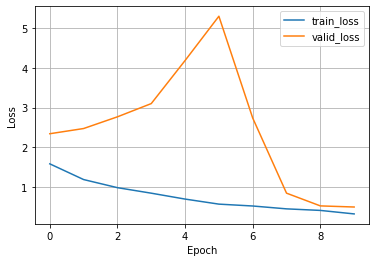

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

metrics = pd.read_csv("../my-results/my-model/version_3/metrics.csv")

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "valid_loss"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
)

plt.show()

# Training and Validation Accuracy

- This only applies if the `main.py` code was run with `--log_accuracy true`

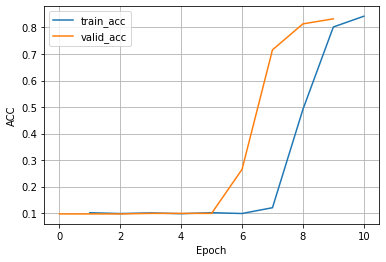

In [2]:
df_metrics = pd.DataFrame(aggreg_metrics)

df_metrics[["train_acc", "valid_acc"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="ACC"
)

plt.show()

# Load Final Model & Check Test Accuracy

- The checkpoint path of the best model (based on validation set performance) should be shown in the scripts output, we copy it below:

In [3]:
path = "../my-results/my-model/version_3/checkpoints/epoch=9-step=870.ckpt"

In [4]:
import pytorch_lightning as pl
import torch

from my_classifier_template.model import LightningClassifier

pytorch_model = torch.hub.load(
    "pytorch/vision:v0.11.0", "mobilenet_v3_large", pretrained=False
)

pytorch_model.classifier[-1] = torch.nn.Linear(
    in_features=1280, out_features=10  # as in original
)  # number of class labels in Cifar-10)


lightning_model = LightningClassifier.load_from_checkpoint(path, model=pytorch_model)
lightning_model.eval();

Using cache found in /Users/sebastian/.cache/torch/hub/pytorch_vision_v0.11.0


In [5]:
from pytorch_lightning import Trainer
from torchvision import transforms

from my_classifier_template.dataset import Cifar10DataModule

custom_test_transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.CenterCrop((224, 224)),
        transforms.ToTensor(),
    ]
)

data_module = Cifar10DataModule(
    batch_size=128,
    data_path="../data",
    num_workers=4,
    test_transform=custom_test_transform,
)

data_module.prepare_data()
data_module.setup()

trainer = Trainer()
trainer.test(model=lightning_model, dataloaders=data_module.test_dataloader())

Files already downloaded and verified


/Users/sebastian/miniforge3/envs/pl/lib/python3.8/site-packages/pytorch_lightning/loops/utilities.py:91: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7760999798774719
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.7760999798774719}]

# Inspecting Failure Cases

- In practice, it is often informative to look at failure cases like wrong predictions for particular training instances as it can give us some insights into the model behavior and dataset.
- Inspecting failure cases can sometimes reveal interesting patterns and even highlight dataset and labeling issues.

In [6]:
class_dict = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}

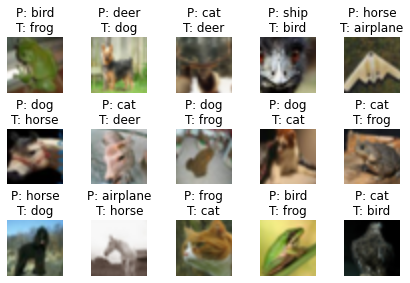

In [7]:
from my_classifier_template.plotting import show_failures

fig, axes = show_failures(
    model=lightning_model,
    data_loader=data_module.test_dataloader(),
    class_dict=class_dict,
)

plt.tight_layout()
plt.show()

- In addition to inspecting failure cases visually, it is also informative to look at which classes the model confuses the most via a confusion matrix:

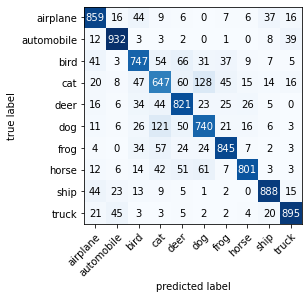

In [11]:
from mlxtend.plotting import plot_confusion_matrix
from torchmetrics import ConfusionMatrix

cmat = ConfusionMatrix(num_classes=len(class_dict))

for x, y in data_module.test_dataloader():

    with torch.no_grad():
        pred = lightning_model(x)
    cmat(pred, y)

cmat_tensor = cmat.compute()
cmat = cmat_tensor.numpy()

fig, ax = plot_confusion_matrix(
    conf_mat=cmat,
    class_names=class_dict.values(),
)
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")

plt.show()

## Optional Save Pure PyTorch Model for Production

In [21]:
x, y = iter(data_module.test_dataloader()).next()

lightning_model.to_onnx(
    file_path="model-for-production.onnx", input_sample=x, export_params=True
)